## CROSS THE ROAD 

Celem projektu było zaprojektowanie i zaimplementowanie własnego środowiska symulacyjnego zgodnego z interfejsem gymnasium, które odzwierciedla uproszczoną wersję klasycznej gry „Cross the Road”. W środowisku tym agent (żaba) próbuje bezpiecznie przejść przez ruchliwą drogę, omijając poruszające się samochody i docierając do celu znajdującego się na górze planszy - jeziora.

Środowisko zostało zaimplementowane w pełni od podstaw, z wykorzystaniem klas i konwencji biblioteki gymnasium, tak aby możliwe było jego bezproblemowe użycie z różnymi algorytmami uczenia przez wzmacnianie. Obejmowało ono m.in.:

- zdefiniowaną przestrzeń obserwacji i akcji (spaces.Box, spaces.Discrete),
- obsługę resetowania i przechodzenia między krokami (reset, step),
- mechanikę poruszania się agenta i pojazdów,
- prosty system nagród oraz warunki zakończenia epizodu,
- wizualizację gry z użyciem biblioteki pygame.

## Import bibliotek

In [ ]:
import numpy as np
import pygame
import gymnasium as gym
from gymnasium import spaces
from enum import Enum
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

## Struktura środowiska

Środowisko symuluje sytuację, w której agent (żaba) musi przejść z dolnej krawędzi siatki do górnej, omijając poruszające się samochody na wyznaczonych pasach ruchu. Rozmiar siatki definiowany jest parametrem size (domyślnie: 7 kolumn na 10 wierszy).

Przestrzeń akcji (action_space): Dyskretna (spaces.Discrete(4)) – odpowiada czterem możliwym kierunkom ruchu: w prawo, w górę, w lewo, w dół.

Przestrzeń stanów (observation_space): Ciągła (spaces.Box) – zawiera pozycję agenta oraz pozycję celu jako wektor 4-floatowy: [agent_x, agent_y, goal_x, goal_y].

### Działanie środowiska

- reset() – ustawia agenta na środku dolnego wiersza oraz cel na środku górnego wiersza. Tworzy pojazdy na wyznaczonych pasach (linie lanes) z ustalonymi kierunkami ruchu.
- is_collision() – sprawdza, czy agent znajduje się w tym samym wierszu co pojazd i czy odległość pozioma jest mniejsza lub równa 0.5, co symuluje potencjalne zderzenie.
- move_cars() – przesuwa każdy pojazd o jeden krok w kierunku jego ruchu, z zastosowaniem toroidalnego przejścia (modulo).
- generate_cars() – tworzy pojazdy w ustalonych kolumnach i wierszach (symulacja pasów).
- step(action) – przemieszcza agenta zgodnie z wybraną akcją i przesuwa samochody. Zwraca nową obserwację, nagrodę oraz informację o zakończeniu epizodu.

 Nagrody:
- +4.0 – osiągnięcie celu (koniec epizodu),
- –2.0 – kolizja z pojazdem (agent resetowany),
- +0.2 – ruch w górę (postęp),
- –0.1 – ruch w dół, brak ruchu lub ruch poziomy bez zmiany pozycji w pionie.


### Wizualizacja (render)

Do wizualizacji wykorzystano bibliotekę pygame. Obiekty w środowisku (agent, pojazdy, cel) są reprezentowane przez obrazy graficzne, przeskalowane do rozmiaru komórki siatki. Obraz jest aktualizowany z częstotliwością ustawioną w metadata["render_fps"].

### Uwagi techniczne

- Samochody poruszają się niezależnie od działań agenta, co wymusza planowanie ruchu.
- Agent po kolizji nie kończy epizodu, lecz jest resetowany do pozycji startowej.
- Obserwacja nie zawiera pozycji samochodów – co utrudnia zadanie i zmusza agenta do nauki strategii wyłącznie na podstawie pozycji celu i swojej.

# Interfejs graficzny 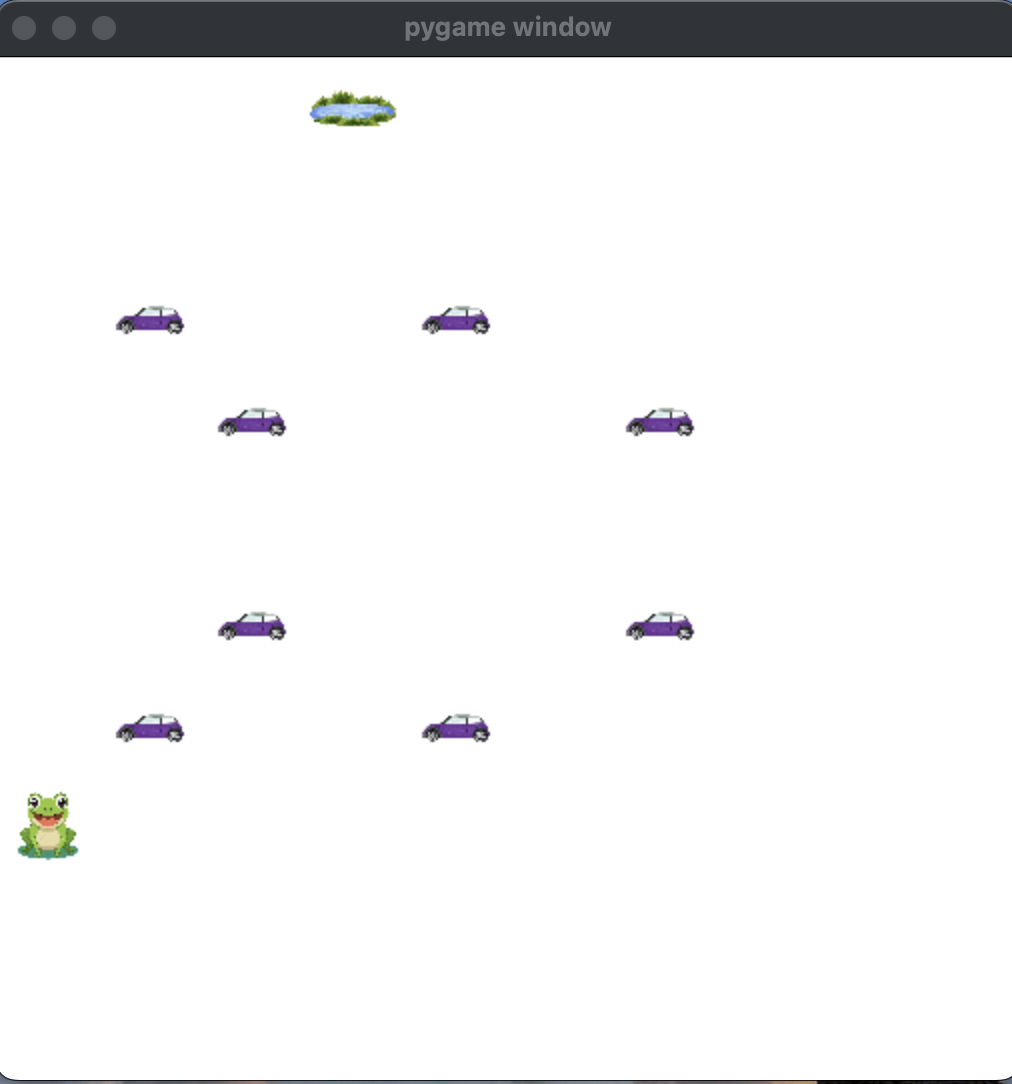

In [4]:
class Actions(Enum):
    RIGHT = 0
    UP = 1
    LEFT = 2
    DOWN = 3

class CrossTheRoadEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, render_mode=None, size=(7, 10)):
        self.grid_width, self.grid_height = size
        self.render_mode = render_mode
        self.window_size = 512

        self.observation_space = spaces.Box(low=0, high=max(size), shape=(4,), dtype=np.float32)
        self.action_space = spaces.Discrete(4)

        self._action_to_direction = {
            Actions.RIGHT.value: np.array([1, 0]),
            Actions.UP.value: np.array([0, 1]),
            Actions.LEFT.value: np.array([-1, 0]),
            Actions.DOWN.value: np.array([0, -1]),
        }

        self.lanes = [3, 4, 6, 7]
        self.agent_pos = None
        self.goal_pos = None
        self.cars = []
        self.window = None
        self.clock = None
        self.car_step_counter = 0
        self.car_step_frequency = 1 
        self.agent_image = None
        self.goal_image = None
        self.car_image = None
        # self.observation_space = spaces.Box(low=0, high=max(size), shape=(8,), dtype=np.float32)



    def _generate_cars(self):
        self.cars = []

        # Na każdym pasie 2 samochody w tych samych kolumnach
        for lane in self.lanes:
            direction = 1 if lane % 2 == 0 else -1
            positions = [0, 3]  # ustalone startowe kolumny
            for x in positions:
                self.cars.append({
                    "start_x": x,
                    "pos": np.array([x, lane]),
                    "dir": direction
                })

    def _move_cars(self):
        for car in self.cars:
            car["pos"][0] = (car["pos"][0] + car["dir"]) % self.grid_width

    def _get_obs(self):
        return np.concatenate((self.agent_pos, self.goal_pos)).astype(np.float32)

    # def _is_collision(self):
    #     return any(np.array_equal(self.agent_pos, car["pos"]) for car in self.cars)

    def _is_collision(self):
        for car in self.cars:
            same_row = self.agent_pos[1] == car["pos"][1]
            horizontal_distance = abs(self.agent_pos[0] - car["pos"][0])
            if same_row and horizontal_distance <= 0.5:
                return True
        return False

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = np.array([self.grid_width // 2, 0])
        self.goal_pos = np.array([self.grid_width // 2, self.grid_height - 1])
        self._generate_cars()
        return self._get_obs(), {}

    def step(self, action):
        direction = self._action_to_direction[int(action)]
        old_x, old_y = self.agent_pos

        self.agent_pos = np.clip(self.agent_pos + direction, [0, 0], [self.grid_width - 1, self.grid_height - 1])
        self._move_cars()

        reward = 0.0
        terminated = False

        if np.array_equal(self.agent_pos, self.goal_pos):
            reward = 4.0
            terminated = True  # epizod się kończy
        elif self._is_collision():
            reward = -2.0
            # terminated = True
            self.agent_pos = np.array([self.grid_width / 2, 0])  # reset agenta
        elif self.agent_pos[1] > old_y:
            reward = 0.2
        elif self.agent_pos[1] < old_y:
            reward = -0.1
        elif self.agent_pos[1] == old_y and self.agent_pos[0] == old_x:
            reward = -0.1
        else:
            reward = -0.1


        return self._get_obs(), reward, terminated, False, {}

 

    def render(self):
        if self.render_mode != "human":
            return

        if self.window is None:
            pygame.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))

        if self.clock is None:
            self.clock = pygame.time.Clock()

        cell_size = self.window_size // self.grid_height

        # Załaduj obrazy tylko raz
        if self.agent_image is None:
            self.agent_image = pygame.image.load("images/zaba.png")
            self.agent_image = pygame.transform.scale(self.agent_image, (cell_size, cell_size))

        if self.goal_image is None:
            self.goal_image = pygame.image.load("images/goal.png")
            self.goal_image = pygame.transform.scale(self.goal_image, (cell_size, cell_size))

        if self.car_image is None:
            self.car_image = pygame.image.load("images/car.png")
            self.car_image = pygame.transform.scale(self.car_image, (cell_size, cell_size))

        self.window.fill((255, 255, 255))  # tło

        # Rysowanie agenta
        agent_pos_px = (self.agent_pos[0]*cell_size,
                        self.window_size - (self.agent_pos[1]+1)*cell_size)
        self.window.blit(self.agent_image, agent_pos_px)

        # Rysowanie celu
        goal_pos_px = (self.goal_pos[0]*cell_size,
                       self.window_size - (self.goal_pos[1]+1)*cell_size)
        self.window.blit(self.goal_image, goal_pos_px)

        # Rysowanie samochodów
        for car in self.cars:
            car_pos_px = (car["pos"][0]*cell_size,
                          self.window_size - (car["pos"][1]+1)*cell_size)
            self.window.blit(self.car_image, car_pos_px)

        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def close(self):
        if self.window:
            pygame.quit()
            self.window = None


## Implementacja agenta REINFORCE z własną siecią neuronową
Do nauki poruszania się w stworzonym środowisku wykorzystano agenta opartego na algorytmie REINFORCE (Policy Gradient). Jest to klasyczna metoda uczenia przez wzmacnianie, w której agent uczy się polityki działania bezpośrednio, na podstawie gradientu oczekiwanej nagrody.

### Architektura sieci polityki – PolicyNet

Do reprezentacji funkcji polityki zastosowano prostą sieć neuronową zbudowaną przy użyciu biblioteki PyTorch.
Sieć przyjmuje na wejściu wektor stanu (pozycja agenta i celu) i zwraca rozkład prawdopodobieństwa dla każdej możliwej akcji. Zastosowanie funkcji softmax na wyjściu pozwala interpretować wartości jako prawdopodobieństwa decyzji.

### Zachowanie agenta – PGAgent

Agent implementuje klasyczny schemat REINFORCE:

- select_action(state) – oblicza prawdopodobieństwa akcji na podstawie aktualnego stanu, losuje jedną z nich (lub wybiera deterministycznie w trybie testowym), i zapisuje logarytm jej prawdopodobieństwa.
- update() – po zakończeniu epizodu oblicza sumy zdyskontowanych nagród (returns), normalizuje je i oblicza gradient względem log-prawdopodobieństw.

Dodatkowo do funkcji straty dodano minimalny komponent entropii, który zachęca politykę do eksploracji.

### Parametry uczenia

- Współczynnik uczenia (lr): 0.001
- Dyskontowanie nagrody (gamma): 0.99
- Minimalna entropia: 0.01
Dzięki tej konstrukcji agent jest w stanie uczyć się przez powtarzane interakcje z otoczeniem, optymalizując strategię poruszania się w kierunku celu i unikania kolizji.

In [5]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return torch.softmax(self.net(x), dim=-1)

# REINFORCE agent
class PGAgent:
    def __init__(self, obs_dim, act_dim, lr=1e-3):
        self.policy = PolicyNet(obs_dim, act_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = 0.99

        self.log_probs = []
        self.rewards = []

    def select_action(self, state, explore=True):
        state = torch.FloatTensor(state)
        probs = self.policy(state)
        dist = torch.distributions.Categorical(probs)
        if explore:
            action = dist.sample()
            self.log_probs.append(dist.log_prob(action))
        else:
            action = torch.argmax(probs)  # deterministyczna akcja
        return action.item()


    def update(self):
        R = 0
        returns = []
        for r in reversed(self.rewards):
            R = r + self.gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # loss = -torch.stack(self.log_probs) * returns
        # loss = loss.sum()
        log_probs = torch.stack(self.log_probs)
        entropy = -log_probs.mean()  # entropia ~ eksploracja
        loss = -(log_probs * returns).sum() - 0.01 * entropy

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.log_probs = []
        self.rewards = []
          

# Proces treningu i testowania agenta
Po zaimplementowaniu środowiska i agenta, przystąpiono do treningu w celu nauczenia agenta strategii umożliwiającej bezpieczne dotarcie do celu w obecności poruszających się przeszkód (samochodów).

## Parametry treningu

- Liczba epizodów: 3000
- Maksymalna liczba kroków na epizod: 200
- Częstotliwość renderowania (pygame): co 200 epizodów
- Przechowywanie nagród z każdego epizodu: episode_rewards

## Przebieg treningu

Trening polegał na cyklicznym wykonywaniu następujących kroków:

- Reset środowiska – agent jest umieszczany na dolnym końcu planszy, a samochody są generowane w ustalonych pasach ruchu.
- Symulacja epizodu – agent w pętli wybiera akcje na podstawie bieżącej polityki i otrzymuje nagrody w zależności od skuteczności:
pozytywne za zbliżenie się do celu lub jego osiągnięcie,
negatywne za kolizję lub cofanie się.
- Zbieranie nagród – każda otrzymana nagroda jest zapisywana do listy agent.rewards.
- Aktualizacja polityki – po zakończeniu epizodu wywoływana jest metoda agent.update(), która oblicza gradient i aktualizuje parametry sieci.
- Zapisywanie sumy nagród – suma nagród za każdy epizod jest zapisywana w episode_rewards, co umożliwia późniejszą analizę procesu uczenia.

## Zapis wytrenowanego modelu

Po zakończeniu treningu polityka agenta została zapisana do pliku:

- torch.save(agent.policy.state_dict(), "policy.pt")
Model ten może być później użyty do testów lub dalszego treningu.

## Testowanie wyuczonego agenta

W trybie testowym agent działa deterministycznie, wybierając akcję o najwyższym prawdopodobieństwie. Przeprowadzono 5 testowych epizodów w celu oceny skuteczności wyuczonej strategii. 
Testy wskazują, czy agent z powodzeniem nauczył się unikania kolizji i osiągania celu w możliwie krótkim czasie.

In [6]:
env = CrossTheRoadEnv(render_mode="human")
agent = PGAgent(obs_dim=env.observation_space.shape[0], act_dim=env.action_space.n)

EPISODES = 3000
RENDER_EVERY = 200
MAX_STEPS = 200

episode_rewards = []

for episode in range(EPISODES):
    state, _ = env.reset()
    done = False
    ep_reward = 0
    step_count = 0

    while not done and step_count < MAX_STEPS:
        action = agent.select_action(state) 
        next_state, reward, done, truncated, _ = env.step(action)
        agent.rewards.append(reward)
        ep_reward += reward
        state = next_state
        step_count += 1

        if episode % RENDER_EVERY == 0:
            env.render()

    agent.update()
    episode_rewards.append(ep_reward)


    if episode % 100 == 0:
        print(f"[TRAIN] Epizod {episode}, suma nagród: {ep_reward:.2f}")


torch.save(agent.policy.state_dict(), "policy.pt")
print("Model zapisany jako policy.pt")


agent.policy.eval()
TEST_EPISODES = 5

print("\n=== TESTOWANIE WYUCZONEGO AGENTA===")
for i in range(TEST_EPISODES):
    state, _ = env.reset()
    done = False
    ep_reward = 0
    step_count = 0

    while not done and step_count < MAX_STEPS:
        action = agent.select_action(state, explore=False)  # deterministycznie
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        ep_reward += reward
        step_count += 1
        env.render()

    print(f"[TEST] Epizod {i+1}: suma nagród = {ep_reward:.2f}")

env.close()


[TRAIN] Epizod 0, suma nagród: -14.30
[TRAIN] Epizod 100, suma nagród: -5.30
[TRAIN] Epizod 200, suma nagród: -0.30
[TRAIN] Epizod 300, suma nagród: 3.30
[TRAIN] Epizod 400, suma nagród: 6.60
[TRAIN] Epizod 500, suma nagród: 4.80
[TRAIN] Epizod 600, suma nagród: 7.60
[TRAIN] Epizod 700, suma nagród: 8.80
[TRAIN] Epizod 800, suma nagród: 9.70
[TRAIN] Epizod 900, suma nagród: 8.40
[TRAIN] Epizod 1000, suma nagród: 9.10
[TRAIN] Epizod 1100, suma nagród: 9.40
[TRAIN] Epizod 1200, suma nagród: 10.00
[TRAIN] Epizod 1300, suma nagród: 10.00
[TRAIN] Epizod 1400, suma nagród: 8.50
[TRAIN] Epizod 1500, suma nagród: 9.40
[TRAIN] Epizod 1600, suma nagród: 9.70
[TRAIN] Epizod 1700, suma nagród: 9.70
[TRAIN] Epizod 1800, suma nagród: 9.70
[TRAIN] Epizod 1900, suma nagród: 10.00
[TRAIN] Epizod 2000, suma nagród: 10.00
[TRAIN] Epizod 2100, suma nagród: 9.70
[TRAIN] Epizod 2200, suma nagród: 9.70
[TRAIN] Epizod 2300, suma nagród: 4.90
[TRAIN] Epizod 2400, suma nagród: 8.40
[TRAIN] Epizod 2500, suma nag

# Analiza wyników treningu i wizualizacja krzywej uczenia
Aby ocenić postęp agenta w trakcie treningu, zapisywano sumę nagród zdobywanych w każdym epizodzie do listy episode_rewards. Na tej podstawie można było wykreślić krzywą uczenia, która odzwierciedla efektywność strategii podejmowanej przez agenta w kolejnych epizodach.

## Interpretacja krzywej

- Początkowe epizody charakteryzują się niską sumą nagród, co wynika z losowych działań agenta i częstych kolizji.
- W miarę postępu treningu widoczny jest trend rosnący, co oznacza, że agent uczy się skuteczniej unikać przeszkód i częściej osiąga cel.
- Średnia krocząca pozwala lepiej zaobserwować ogólny kierunek postępu i eliminować chwilowe fluktuacje.


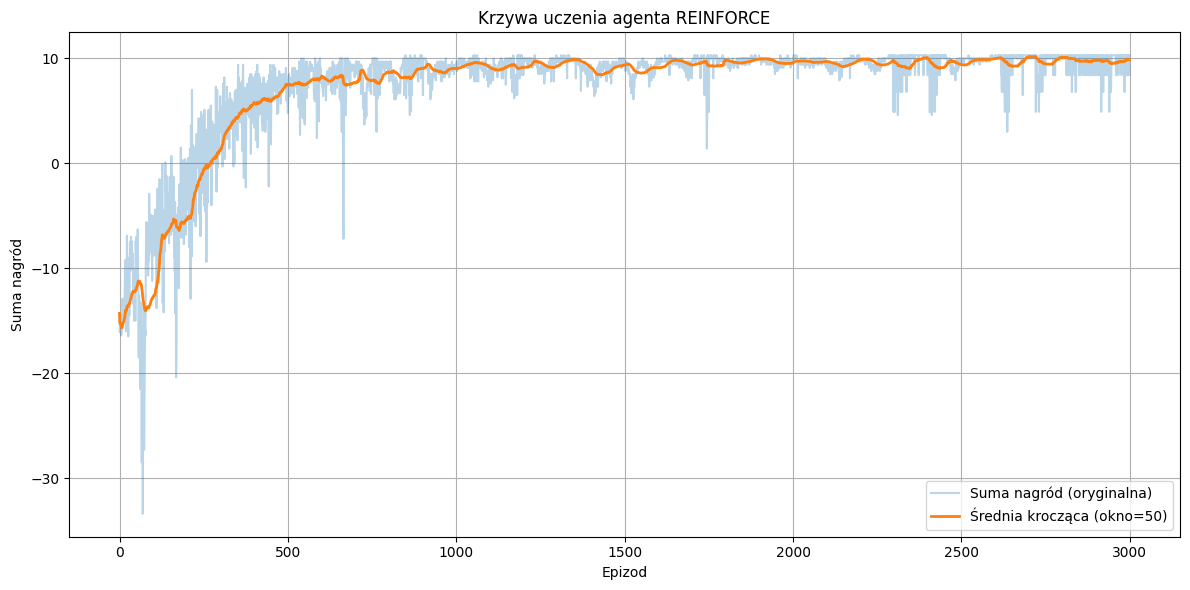

In [7]:
window = 50
rolling_rewards = pd.Series(episode_rewards).rolling(window, min_periods=1).mean()

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label="Suma nagród (oryginalna)", alpha=0.3)
plt.plot(rolling_rewards, label=f"Średnia krocząca (okno={window})", linewidth=2)
plt.xlabel("Epizod")
plt.ylabel("Suma nagród")
plt.title("Krzywa uczenia agenta REINFORCE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Wnioski końcowe
Projekt pokazuje, że możliwe jest zbudowanie własnego środowiska uczenia przez wzmacnianie zgodnego z gymnasium oraz skuteczne nauczenie agenta zachowania przy użyciu klasycznego algorytmu REINFORCE. Pomimo ograniczonych informacji wejściowych (agent nie widzi samochodów), nauczył się podejmować sensowne decyzje tylko na podstawie własnej pozycji i celu.

## Możliwe kierunki dalszego rozwoju:

- dodanie do obserwacji położenia pojazdów,
- różnicowanie prędkości samochodów,
- wprowadzenie wielu celów lub dynamicznych przeszkód,
- przetestowanie innych algorytmów (np. PPO, DQN).